## Neuron Playground: Interactive intuition + backprop mini‑lab

This notebook complements `neuron.ipynb` with hands‑on, interactive visuals:

- Activation explorer (step, sigmoid, tanh, ReLU, leaky ReLU, softplus, GELU) with derivative overlay
- Single 2D neuron decision boundary (weights/bias sliders) with probability heatmap
- Weighted sum playground (tweak inputs, weights, bias; see activations)
- Backprop mini‑lab (single neuron, MSE): gradients, one‑step updates, and contour view of L(w1, w2)

Tip: Run the cells from top to bottom. If a dependency is missing, the setup cell below can install it in‑notebook.


In [1]:
# Setup (run once)
import sys
import subprocess

def _ensure(package):
    try:
        __import__(package)
    except Exception:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# ipywidgets for interactivity
_ensure('ipywidgets')
_ensure('matplotlib')
_ensure('numpy')
_ensure('scipy')
_ensure('pandas')

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Checkbox
from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 120


### Activation explorer: why derivatives and ranges?

- **What is a derivative (in plain words)?** The derivative is the curve’s local slope at a point. It tells you how sensitive the output is to a tiny change in the input right there.
  - Positive slope → increase input a little, output goes up.
  - Negative slope → increase input a little, output goes down.
  - Near zero slope → the curve is flat there; small input changes barely affect the output.
  - Bigger magnitude → more sensitivity (a small input nudge causes a larger output nudge).
- **What is a gradient?** When something depends on many variables (e.g., many weights), the gradient is the collection of all those slopes—one per variable. It points toward the direction of fastest increase. Learning uses the opposite direction (downhill) to reduce error.
- **In this plot:** The dashed line shows the derivative of the activation with respect to its input z (the neuron’s weighted sum). It answers: “If z changes a tiny bit, how much does the activation change?”
- **Why this matters for learning/backprop:** Backprop chains these slopes through layers. If slopes are very small in many places, signals shrink (vanishing gradients) and learning becomes slow. If slopes are very large, updates can be unstable (exploding gradients).

- **Examples of derivative behavior across activations**
  - **sigmoid**: derivative ≤ 0.25 and goes to 0 for large |x| (vanishing gradients in saturation).
  - **tanh**: similar shape but centered at 0; derivative peaks at 1 and also vanishes in saturation.
  - **ReLU**: derivative is 0 for x<0 and 1 for x>0 (sparse gradients; no saturation on the positive side).
  - **leaky ReLU / softplus / GELU**: smooth or non‑zero negative‑side slopes to improve gradient flow.
- **Why these min/max sliders?** In practice, inputs or pre‑activations z often fall roughly in [−6, 6] for normalized data and well‑scaled weights. That range lets you see both linear and saturated regions for sigmoid/tanh, and enough negative/positive range for ReLU variants. You can widen it to explore edge behavior.
- **Common choices today**
  - **Hidden layers**: ReLU is a strong default; **Leaky ReLU** (α≈0.01–0.2), **GELU** or **SiLU/Swish** are common in modern architectures.
  - **Output layers**: sigmoid (binary), softmax (multiclass), tanh (bounded symmetric outputs), identity/linear (regression).


In [2]:
# Activation explorer with derivative overlay

def step(x):
	return (x > 0).astype(float)

def sigmoid(x):
	return 1.0 / (1.0 + np.exp(-x))

def tanh(x):
	return np.tanh(x)

def relu(x):
	return np.maximum(0.0, x)

def leaky_relu(x, alpha=0.01):
	return np.where(x > 0, x, alpha * x)

def softplus(x):
	# stable softplus
	return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def gelu(x):
	# tanh approximation
	return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

# Derivatives

def d_step(x):
	return np.zeros_like(x)  # undefined at 0; show 0 for visualization

def d_sigmoid(x):
	s = sigmoid(x)
	return s * (s - 1) * -1  # s*(1-s)

def d_tanh(x):
	t = tanh(x)
	return 1 - t**2

def d_relu(x):
	return (x > 0).astype(float)

def d_leaky_relu(x, alpha=0.01):
	g = np.ones_like(x)
	g[x < 0] = alpha
	g[x == 0] = alpha  # arbitrary
	return g

def d_softplus(x):
	return sigmoid(x)

def d_gelu(x):
	# derivative of tanh approximation
	c = np.sqrt(2/np.pi)
	t = np.tanh(c * (x + 0.044715 * x**3))
	sech2 = 1 - t**2
	inner = c * (1 + 0.134145 * x**2)
	return 0.5 * (1 + t) + 0.5 * x * sech2 * inner

_act = {
	"step": (step, d_step),
	"sigmoid": (sigmoid, d_sigmoid),
	"tanh": (tanh, d_tanh),
	"relu": (relu, d_relu),
	"leaky_relu": (leaky_relu, d_leaky_relu),
	"softplus": (softplus, d_softplus),
	"gelu": (gelu, d_gelu),
}

@interact(
	name=Dropdown(options=list(_act.keys()), value='sigmoid', description='activation'),
	xmin=FloatSlider(-6, min=-10, max=0, step=0.5, description='xmin'),
	xmax=FloatSlider(6, min=0, max=10, step=0.5, description='xmax'),
	show_deriv=Checkbox(True, description='show derivative'),
)
def _activation_explorer(name, xmin, xmax, show_deriv):
	x = np.linspace(xmin, xmax, 800)
	f, df = _act[name]
	if name == 'leaky_relu':
		y = f(x, 0.02)
		dy = df(x, 0.02)
	else:
		y = f(x)
		dy = df(x)
	plt.figure(figsize=(6,3.6))
	plt.plot(x, y, label=name)
	if show_deriv:
		plt.plot(x, dy, '--', label=f'd{name}')
	plt.axhline(0, color='k', linewidth=0.5)
	plt.axvline(0, color='k', linewidth=0.5)
	plt.grid(True, linestyle='--', alpha=0.5)
	plt.legend()
	plt.title('Activation and derivative')
	plt.show()


interactive(children=(Dropdown(description='activation', index=1, options=('step', 'sigmoid', 'tanh', 'relu', …

### Weighted sum playground: how inputs, weights, and bias form z

- **Computation:** z = i1·w1 + i2·w2 + b. The activation a = f(z) then produces the neuron’s output.
- **Visual schema:** See the diagram in the next cell (inputs → weighted sum + bias → activation → output).
- **During learning/backprop (non-technical):**
  - We measure an error (loss) between the output a and the target y.
  - We compute sensitivities (gradients): how changing each weight or the bias would change that loss.
  - We nudge weights and bias a little in the downhill direction to reduce the loss.
- **Can weights be negative?** Yes. A negative weight means the input inhibits the neuron (increases input lowers z). Positive weights excite the neuron (increases input raises z). Bias shifts the threshold left/right.


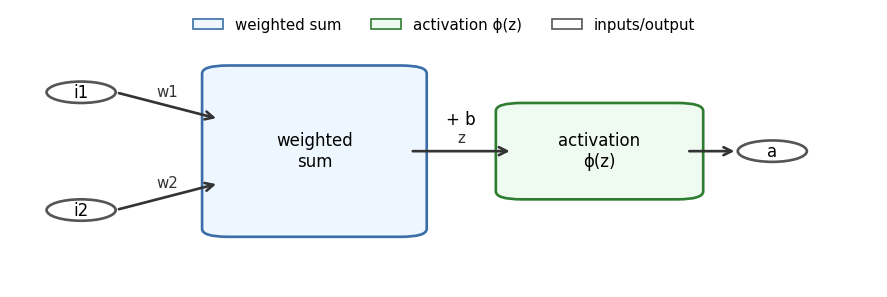

In [3]:
# Visual schema: inputs, weighted sum, bias, activation, output
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch, Patch

fig, ax = plt.subplots(figsize=(7.5, 2.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Helpers

def draw_box(ax, x, y, w, h, text, facecolor='#f0f4ff', edgecolor='#3b6ea8'):
	box = FancyBboxPatch((x, y), w, h, boxstyle='round,pad=0.02,rounding_size=0.03',
						 fc=facecolor, ec=edgecolor, lw=1.6)
	ax.add_patch(box)
	ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=10)
	return box

def draw_circle(ax, x, y, r, text=None, facecolor='#ffffff', edgecolor='#555555'):
	circ = Circle((x, y), r, fc=facecolor, ec=edgecolor, lw=1.6)
	ax.add_patch(circ)
	if text is not None:
		ax.text(x, y, text, ha='center', va='center', fontsize=10)
	return circ

def draw_arrow(ax, start, end, text=None):
	arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=12, lw=1.6, color='#333333')
	ax.add_patch(arrow)
	if text is not None:
		x = (start[0] + end[0]) / 2
		y = (start[1] + end[1]) / 2
		ax.text(x, y + 0.05, text, ha='center', va='center', fontsize=9, color='#333333')
	return arrow

# Nodes
i1 = draw_circle(ax, 0.08, 0.72, 0.04, text='i1')
i2 = draw_circle(ax, 0.08, 0.28, 0.04, text='i2')

sum_box = draw_box(ax, 0.24, 0.20, 0.22, 0.60, 'weighted\nsum', facecolor='#eef7ff')

act_box = draw_box(ax, 0.58, 0.34, 0.20, 0.32, 'activation\nϕ(z)', facecolor='#effaf0', edgecolor='#2f7d31')

out = draw_circle(ax, 0.88, 0.50, 0.04, text='a')

# Connections
draw_arrow(ax, (0.12, 0.72), (0.24, 0.62), text='w1')
draw_arrow(ax, (0.12, 0.28), (0.24, 0.38), text='w2')

# z arrow and +b hint
draw_arrow(ax, (0.46, 0.50), (0.58, 0.50), text='z')
ax.text(0.52, 0.62, '+ b', ha='center', va='center', fontsize=10)

# activation to output
draw_arrow(ax, (0.78, 0.50), (0.84, 0.50))

# Legend
legend_handles = [
	Patch(facecolor='#eef7ff', edgecolor='#3b6ea8', label='weighted sum'),
	Patch(facecolor='#effaf0', edgecolor='#2f7d31', label='activation ϕ(z)'),
	Patch(facecolor='#ffffff', edgecolor='#555555', label='inputs/output')
]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.05),
		   ncol=3, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


In [4]:
# Weighted sum playground: inputs, weights, bias, activation

@interact(
	i1=FloatSlider(1.0, min=-5, max=5, step=0.1, description='i1'),
	i2=FloatSlider(0.5, min=-5, max=5, step=0.1, description='i2'),
	w1=FloatSlider(1.0, min=-5, max=5, step=0.1, description='w1'),
	w2=FloatSlider(-0.5, min=-5, max=5, step=0.1, description='w2'),
	b=FloatSlider(0.0, min=-5, max=5, step=0.1, description='bias'),
	activation=Dropdown(options=['sigmoid','tanh','relu','softplus','step'], value='sigmoid'),
)
def _weighted_sum_playground(i1, i2, w1, w2, b, activation):
	inputs = np.array([i1, i2])
	weights = np.array([w1, w2])
	z = np.dot(inputs, weights) + b
	if activation == 'sigmoid':
		a = sigmoid(z)
	elif activation == 'tanh':
		a = tanh(z)
	elif activation == 'relu':
		a = relu(z)
	elif activation == 'softplus':
		a = softplus(z)
	else:
		a = step(z)
	print(f"z = inputs·weights + b = {z:.4f}")
	print(f"a = {activation}(z) = {a:.4f}")


interactive(children=(FloatSlider(value=1.0, description='i1', max=5.0, min=-5.0), FloatSlider(value=0.5, desc…

### 2D decision boundary: how z and a are shown here (vs previous cell)

- Previously, we computed a single weighted sum z and activation a for one pair of inputs (i1, i2).
- Here, we evaluate z = w1·x1 + w2·x2 + b on a whole grid of points (x1, x2), then show the activation a for each point as a color.
- Heatmap colors = activation a(x1, x2):
  - For sigmoid: this can be read as probability p(y=1|x).
  - For tanh: we plot (tanh(z) + 1) / 2 so the colors fit 0–1.
  - For ReLU/softplus: we show a clipped/normalized view for readability (not a true probability).
- The white line labeled z=0 is the decision boundary (the set of points where the weighted sum changes sign). For sigmoid, it roughly corresponds to p ≈ 0.5 on that line.
- Sliders control w1, w2, b:
  - w1, w2 change the orientation/slope of the boundary.
  - b shifts the boundary left/right or up/down.
- Use the x/y range sliders to zoom the view.


In [5]:
# 2D decision boundary explorer with probability heatmap

@interact(
	w1=FloatSlider(1.0, min=-5, max=5, step=0.1, description='w1'),
	w2=FloatSlider(1.0, min=-5, max=5, step=0.1, description='w2'),
	b=FloatSlider(0.0, min=-5, max=5, step=0.1, description='bias'),
	activation=Dropdown(options=['sigmoid','tanh','relu','softplus','step'], value='sigmoid'),
	xmin=FloatSlider(-3, min=-5, max=0, step=0.5, description='xmin'),
	xmax=FloatSlider(3, min=0, max=5, step=0.5, description='xmax'),
	ymin=FloatSlider(-3, min=-5, max=0, step=0.5, description='ymin'),
	ymax=FloatSlider(3, min=0, max=5, step=0.5, description='ymax'),
)
def _decision_boundary(w1, w2, b, activation, xmin, xmax, ymin, ymax):
	xx, yy = np.meshgrid(
		np.linspace(xmin, xmax, 200),
		np.linspace(ymin, ymax, 200),
	)
	z = w1 * xx + w2 * yy + b
	if activation == 'sigmoid':
		p = sigmoid(z)
	elif activation == 'tanh':
		p = (tanh(z) + 1) / 2
	elif activation == 'relu':
		p = np.clip(relu(z) / (1 + np.abs(z)), 0, 1)
	elif activation == 'softplus':
		p = np.clip(softplus(z) / (1 + np.abs(z)), 0, 1)
	else:
		p = step(z)
	plt.figure(figsize=(6,5))
	cf = plt.contourf(xx, yy, p, levels=50, cmap='viridis')
	cs = plt.contour(xx, yy, z, levels=[0.0], colors='white', linewidths=2)
	plt.clabel(cs, fmt={0.0: 'z=0'}, inline=True)
	plt.colorbar(cf, label='activation/probability')
	plt.title('Neuron decision boundary and activation heatmap')
	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.grid(alpha=0.2)
	plt.show()


interactive(children=(FloatSlider(value=1.0, description='w1', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

### Backprop mini‑lab (single neuron, MSE)

- **What is a labeled sample?** One training example with inputs and the desired answer: `(x1, x2, y)`.
  - `x1, x2`: the features fed into the neuron
  - `y`: the target output we want (for sigmoid, usually 0 or 1)

- **Connection to previous cells**
  - Earlier, we only did the forward pass: compute `z = w1·x1 + w2·x2 + b` and `a = ϕ(z)` for a chosen input. The heatmap showed `a` over many inputs `(x1, x2)` and drew the `z = 0` boundary in input space.
  - Here, we fix a single input `(x1, x2)` and ask a different question: “How should we change the parameters `(w1, w2, b)` so the neuron’s output `a` gets closer to the target `y`?” This is the learning step.

- **What this cell does**
  - Computes the current `z`, activation `a`, and the error (“loss”) for your chosen `(x1, x2, y)`.
  - Computes sensitivities (gradients) telling us how much the loss would change if we nudged each parameter (`w1`, `w2`, `b`) a tiny bit.
  - Takes one small downhill step (size set by the learning rate `lr`) to reduce the loss, and reports the new parameters and new loss.
  - Optionally plots contours of the loss `L(w1, w2)` while keeping `b` fixed, so you can see where “downhill” lies in parameter space. You’ll see:
    - Cyan point: current `(w1, w2)`
    - Yellow point: after one step
    - Green arrow: update direction

- **Learning rate slider (`lr`)**
  - Sets the step size for each update. Smaller `lr` → safer but slower; larger `lr` → faster but can overshoot and increase the loss.
  - A practical way to feel it: start around 0.05–0.3, try larger; if loss jumps up after a step or oscillates, reduce `lr`.

- **Different views, different spaces**
  - Heatmap cell: input space `(x1, x2)` → color shows output `a`.
  - This mini‑lab: parameter space `(w1, w2)` → contours show loss `L` for your fixed input/target. Numbers on contours are the actual loss values.

- **Loss formula (plain words)**
  - `L = 1/2 · (a − y)^2` measures how far the output `a` is from the target `y`; the 1/2 is a convenience and doesn’t change what is “better/worse”.
  - Example (y=1): if `a=0.6` then `L ≈ 0.08`; if `a=0.4` then `L ≈ 0.18` (closer to 1 is better, so smaller loss).
  - Example (y=0): if `a=0.2` then `L ≈ 0.02`; if `a=0.8` then `L ≈ 0.32` (closer to 0 is better).

- **Why use MSE here instead of cross‑entropy?**
  - Simplicity for a single example: easy to read and visualize as smooth contours.
  - For classification with sigmoid outputs, cross‑entropy is usually preferred because it gives stronger learning signals when the model is confidently wrong and aligns with probabilistic modeling (maximum likelihood).
  - You’ll see cross‑entropy in the multi‑sample demo below; the learning mechanics are the same (loss → gradients → step), only the loss shape differs.

- **What are the gradients `dL/dw1`, `dL/dw2`, `dL/db`?**
  - They are the slopes of the loss with respect to each parameter: how much `L` changes if you nudge that parameter a tiny bit.
  - Intuition via dependencies:
    - `z = w1·x1 + w2·x2 + b` → changing `w1` by a small amount changes `z` by about `x1` times that amount. So `dL/dw1 = (dL/dz) · x1`.
    - Similarly, `dL/dw2 = (dL/dz) · x2` and `dL/db = dL/dz` (bias shifts `z` directly).
    - For MSE with activation `a = ϕ(z)`, we have `dL/dz = (a − y) · ϕ’(z)` (loss mismatch times activation slope).
  - The printed gradients tell you the direction to change each parameter to reduce `L` (we move a small step in the negative gradient direction).
  - Notation: `d` means a tiny change/derivative. Read `dL` as “a tiny change in loss,” and `dL/dw1` as “slope of `L` with respect to `w1`.” Likewise `ϕ’(z)` is the derivative (slope) of the activation at `z`. 

- **Why activation slopes matter**
  - The gradients include the activation’s local slope (its derivative). In flat/saturated regions, slopes are tiny → tiny gradients → tiny updates (slow learning). In steeper regions, updates are larger.

Loss: `L = 1/2 · (a − y)^2` where `a = ϕ(z)` and `z = w1·x1 + w2·x2 + b`. For classification with sigmoid, cross‑entropy is common (used later), but the learning idea—compute loss, compute gradients, step downhill—is the same.


#### What are loss contours? What do the numbers mean?

- A contour line connects all parameter pairs `(w1, w2)` that give the same loss value `L` for the fixed input `(x1, x2)`, target `y`, and bias `b`.
- The numbers printed on the lines are the actual loss values `L` on those lines (lower is better). With MSE and a sigmoid output, `L` ranges from 0 (perfect) up to about 0.5 (very wrong for y=0/1).
- Moving perpendicular to the contours changes the loss the fastest (that direction is the negative gradient direction we step toward).
- Near a good solution, contours look like nested ovals around a low point; tightly packed lines indicate a steep region; widely spaced lines indicate a flat region.

#### Concrete numeric example (sigmoid + MSE)

Consider a single labeled sample `(x1, x2, y) = (1.0, 2.0, 1.0)` and bias `b = 0`.
We vary `(w1, w2)` to see how `z`, activation `a = sigmoid(z)`, and loss `L = 1/2·(a−y)^2` change:

| w1 | w2  | z = w1·x1 + w2·x2 + b | a = sigmoid(z) | y   | L = 1/2·(a−y)^2 |
|----|-----|------------------------|----------------|-----|------------------|
| 0.5 | −0.5 | −0.5                   | 0.378          | 1.0 | 0.193            |
| 1.5 | −0.5 | 0.5                    | 0.622          | 1.0 | 0.071            |
| 0.5 | −1.5 | −2.5                   | 0.076          | 1.0 | 0.427            |

- Interpretation:
  - Moving `w1` up from 0.5 to 1.5 raised `z` and `a`, bringing `a` closer to `y=1.0` and lowering `L` (from ~0.193 to ~0.071).
  - Making `w2` more negative at `−1.5` pushed `z` further negative, `a` got smaller, and the loss increased (~0.427).
- In the contour plot, each of these `(w1, w2)` points lies on a contour labeled by its loss (e.g., around `0.19`, `0.07`, or `0.43`). The update arrow points roughly toward lower‑valued contours.

The cyan/yellow points and green arrow show where you are and where one learning step moves you.


In [6]:
def _select_activation(name):
	if name == 'sigmoid':
		return sigmoid, d_sigmoid
	if name == 'tanh':
		return tanh, d_tanh
	if name == 'relu':
		return relu, d_relu
	if name == 'softplus':
		return softplus, d_softplus
	return sigmoid, d_sigmoid

@interact(
	x1=FloatSlider(1.0, min=-3, max=3, step=0.1, description='x1'),
	x2=FloatSlider(2.0, min=-3, max=3, step=0.1, description='x2'),
	y=FloatSlider(1.0, min=0, max=1, step=0.05, description='y'),
	w1=FloatSlider(0.5, min=-3, max=3, step=0.05, description='w1'),
	w2=FloatSlider(-0.5, min=-3, max=3, step=0.05, description='w2'),
	b=FloatSlider(0.0, min=-3, max=3, step=0.05, description='b'),
	lr=FloatSlider(0.1, min=0.001, max=1.0, step=0.001, readout_format='.3f', description='lr'),
	activation=Dropdown(options=['sigmoid','tanh','relu','softplus'], value='sigmoid', description='act'),
	show_contours=Checkbox(True, description='show contours'),
)
def _backprop_one_sample(x1, x2, y, w1, w2, b, lr, activation, show_contours):
	f, df = _select_activation(activation)
	z = w1 * x1 + w2 * x2 + b
	a = f(z)
	L = 0.5 * (a - y) ** 2
	# dL/da = (a - y), da/dz = f'(z), dz/dw1 = x1, dz/dw2 = x2, dz/db = 1
	dL_dz = (a - y) * df(np.array([z]))[0]
	dL_dw1 = dL_dz * x1
	dL_dw2 = dL_dz * x2
	dL_db = dL_dz
	print(f"z={z:.4f}, a={a:.4f}, L={L:.6f}")
	print(f"gradients: dL/dw1={dL_dw1:.6f}, dL/dw2={dL_dw2:.6f}, dL/db={dL_db:.6f}")
	w1_new = w1 - lr * dL_dw1
	w2_new = w2 - lr * dL_dw2
	b_new = b - lr * dL_db
	z_new = w1_new * x1 + w2_new * x2 + b_new
	a_new = f(z_new)
	L_new = 0.5 * (a_new - y) ** 2
	print(f"after 1 step: w1={w1_new:.4f}, w2={w2_new:.4f}, b={b_new:.4f}, L={L_new:.6f}")
	if show_contours:
		# show L(w1,w2) contours at fixed b
		w1s = np.linspace(w1 - 2, w1 + 2, 100)
		w2s = np.linspace(w2 - 2, w2 + 2, 100)
		WW1, WW2 = np.meshgrid(w1s, w2s)
		Z = WW1 * x1 + WW2 * x2 + b
		A = f(Z)
		Loss = 0.5 * (A - y) ** 2
		plt.figure(figsize=(6,5))
		cs = plt.contour(WW1, WW2, Loss, levels=20, cmap='magma')
		plt.clabel(cs, inline=True, fontsize=8)
		plt.scatter([w1], [w2], c='cyan', edgecolors='k', label='current')
		plt.scatter([w1_new], [w2_new], c='yellow', edgecolors='k', label='after step')
		plt.quiver([w1], [w2], [w1_new - w1], [w2_new - w2], angles='xy', scale_units='xy', scale=1, color='lime', width=0.005, label='update')
		plt.xlabel('w1')
		plt.ylabel('w2')
		plt.title('Loss contours L(w1,w2) at fixed b')
		plt.legend()
		plt.grid(alpha=0.2)
		plt.show()


interactive(children=(FloatSlider(value=1.0, description='x1', max=3.0, min=-3.0), FloatSlider(value=2.0, desc…

### Multi-sample gradient descent (toy dataset)

- **What this builds on**
  - From the single‑sample mini‑lab, you saw: loss, gradients, and one step for a single `(x1, x2, y)`.
  - From the decision‑boundary heatmap, you saw: how `z = w1·x1 + w2·x2 + b` and activation `a` vary over input space.
  - Here, we combine both ideas over a whole dataset and update parameters repeatedly (epochs).

- **Data**
  - We generate a tiny 2‑class dataset with two clusters (roughly linearly separable). Each point is an input `(x1, x2)` with a label `y ∈ {0,1}`.
  - The `seed` slider reshuffles the random draw.
  - You can preview the dataset in a table (see the toggle in the cell below).

- **Model**
  - A single logistic neuron: `z = w1·x1 + w2·x2 + b`, `a = sigmoid(z)` interpreted as `p(y=1|x)`.
  - Where it’s used: logistic regression (classic baseline classifier), final layer of binary classifiers, and as a building block inside larger neural networks.

- **Loss (cross‑entropy, averaged over samples)**
  - `L = −mean( y·log(a) + (1−y)·log(1−a) )`.
  - With sigmoid + cross‑entropy, per‑example `dL/dz = a − y` (same chain rule idea as before).

- **Updates over epochs**
  - Average gradients: `dL/dw = mean( (a−y)·x )`, `dL/db = mean(a−y)`.
  - Update: `w ← w − lr·dL/dw`, `b ← b − lr·dL/db`, repeated for `epochs` steps.

- **What the plots show**
  - Left: data and the learned decision boundary/heatmap after training.
    - Blue/orange points are the two classes.
    - Black line is `z=0` (decision boundary); colored background is `a = sigmoid(z)` = `p(y=1|x)`.
  - Right: training loss (binary cross‑entropy) as it changes over epochs.
    - Lower and smoother is better; if it increases or oscillates, try a smaller `lr` or different initialization.
    - `epochs` and `lr` most strongly affect this curve: more epochs → more chances to descend; `lr` controls step size.

- **Links to earlier cells**
  - The `z=0` boundary is the same concept as in the 2D boundary explorer, now positioned by training instead of sliders.
  - Gradients/updates are the same idea as the single‑sample backprop lab, now averaged across many samples each epoch.

- **Sliders**
  - `epochs`: number of training passes.
  - `lr`: learning rate (step size). Too large → oscillation/divergence; too small → slow.
  - `w1_0`, `w2_0`, `b0`: starting parameters (affect convergence speed and direction).

Tip: If the classes overlap, a single straight line cannot perfectly separate them; expect a non‑zero loss at convergence.

In [ ]:
def _make_toy_data(n=40, seed=0):
	rng = np.random.default_rng(seed)
	x1_pos = rng.normal(loc=1.0, scale=0.6, size=n//2)
	x2_pos = rng.normal(loc=1.0, scale=0.6, size=n//2)
	x1_neg = rng.normal(loc=-1.0, scale=0.6, size=n//2)
	x2_neg = rng.normal(loc=-1.0, scale=0.6, size=n//2)
	X = np.vstack([
		np.stack([x1_pos, x2_pos], axis=1),
		np.stack([x1_neg, x2_neg], axis=1),
	])
	y = np.concatenate([np.ones(n//2), np.zeros(n//2)])
	return X, y

@interact(
	seed=IntSlider(0, min=0, max=999, step=1, description='seed'),
	epochs=IntSlider(20, min=1, max=200, step=1, description='epochs'),
	lr=FloatSlider(0.1, min=0.001, max=1.0, step=0.001, readout_format='.3f', description='lr'),
	b_init=FloatSlider(0.0, min=-3, max=3, step=0.1, description='b0'),
	w1_init=FloatSlider(0.0, min=-2, max=2, step=0.1, description='w1_0'),
	w2_init=FloatSlider(0.0, min=-2, max=2, step=0.1, description='w2_0'),
	show_data=Checkbox(False, description='show data table'),
	
)
def _logistic_gd(seed, epochs, lr, b_init, w1_init, w2_init, show_data):
	X, y = _make_toy_data(40, seed)
	if show_data:
		df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': y.astype(int)})
		display(df)
	w = np.array([w1_init, w2_init], dtype=float)
	b = float(b_init)
	losses = []
	for _ in range(epochs):
		z = X @ w + b
		a = sigmoid(z)
		# binary cross-entropy loss
		L = -np.mean(y * np.log(a + 1e-9) + (1 - y) * np.log(1 - a + 1e-9))
		losses.append(L)
		dL_dz = a - y  # d/dz of CE with sigmoid
		dL_dw = X.T @ dL_dz / len(X)
		dL_db = np.mean(dL_dz)
		w -= lr * dL_dw
		b -= lr * dL_db
	# plot data and decision boundary
	plt.figure(figsize=(10,4))
	plt.subplot(1,2,1)
	plt.scatter(X[y==1,0], X[y==1,1], c='tab:blue', label='y=1')
	plt.scatter(X[y==0,0], X[y==0,1], c='tab:orange', label='y=0')
	xmin, xmax = X[:,0].min()-1, X[:,0].max()+1
	ymin, ymax = X[:,1].min()-1, X[:,1].max()+1
	xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))
	zz = w[0] * xx + w[1] * yy + b
	pp = sigmoid(zz)
	plt.contour(xx, yy, zz, levels=[0.0], colors='k', linewidths=2)
	cf = plt.contourf(xx, yy, pp, levels=50, cmap='viridis', alpha=0.7)
	plt.colorbar(cf, label='p(y=1|x)')
	plt.legend()
	plt.title('Logistic neuron after training')
	plt.xlabel('x1'); plt.ylabel('x2'); plt.grid(alpha=0.2)
	plt.subplot(1,2,2)
	plt.plot(losses, label='loss')
	plt.xlabel('epoch'); plt.ylabel('binary cross-entropy')
	plt.title('Training loss')
	plt.grid(True, linestyle='--', alpha=0.5)
	plt.legend()
	plt.tight_layout()
	plt.show()
	print(f"Final params: w={w}, b={b:.3f}")


interactive(children=(IntSlider(value=0, description='seed', max=999), IntSlider(value=20, description='epochs…

### Optional: 3D surface of activation a(z) over (x1, x2)

- **Why 3D?** Earlier, you saw 2D heatmaps of activation `a` over `(x1, x2)` for a fixed parameter set. The 3D surface shows the same thing with height as `a`, which makes slopes/flat regions easier to spot. Steep areas (large slope) mean larger gradients; flat plateaus mean small gradients (slow learning).
- **Rotate the view:** Use the sliders to change azimuth/elevation and see the surface from different angles.
- **Link to learning:** Where the surface is steep around your current `(x1, x2)`, gradient descent takes larger steps; where it is flat, steps are smaller.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

@interact(
	w1=FloatSlider(1.0, min=-2, max=2, step=0.1),
	w2=FloatSlider(1.0, min=-2, max=2, step=0.1),
	b=FloatSlider(0.0, min=-2, max=2, step=0.1),
	activation=Dropdown(options=['sigmoid','tanh','relu','softplus'], value='sigmoid'),
	azim=IntSlider(45, min=0, max=360, step=5, description='azimuth'),
	elev=IntSlider(25, min=0, max=90, step=5, description='elevation'),
)
def _activation_surface(w1, w2, b, activation, azim, elev):
	f, _ = _select_activation(activation)
	x = np.linspace(-3, 3, 60)
	y = np.linspace(-3, 3, 60)
	XX, YY = np.meshgrid(x, y)
	Z = w1 * XX + w2 * YY + b
	A = f(Z)
	fig = plt.figure(figsize=(7,5))
	ax = fig.add_subplot(111, projection='3d')
	surf = ax.plot_surface(XX, YY, A, cmap='viridis', linewidth=0, antialiased=True, alpha=0.85)
	fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.1, label='activation a(z)')
	ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('activation')
	ax.set_title(f'{activation} surface a(z)')
	ax.view_init(elev=elev, azim=azim)
	plt.show()


interactive(children=(FloatSlider(value=1.0, description='w1', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…